In [1]:
# ===== 1. Simple CNN =====
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv1D, MaxPooling1D

DATASET_DIR = '/content/drive/MyDrive/Col/머신러닝 10주차/UCI HAR Dataset'

def load_file(p): return pd.read_csv(p, header=None, sep=r"\s+", engine="python").values
def load_group(files, pref): return np.dstack([load_file(os.path.join(pref, f)) for f in files])
def load_dataset_group(g, root):
    pref = os.path.join(root, g, 'Inertial Signals')
    files = [f'total_acc_{a}_{g}.txt' for a in 'xyz'] + \
            [f'body_acc_{a}_{g}.txt' for a in 'xyz'] + \
            [f'body_gyro_{a}_{g}.txt' for a in 'xyz']
    X = load_group(files, pref)
    y = load_file(os.path.join(root, g, f'y_{g}.txt')).ravel().astype(int)
    return X, y

def load_dataset(root):
    trX, try_ = load_dataset_group('train', root)
    teX, tey  = load_dataset_group('test',  root)
    try_, tey = try_-1, tey-1
    return trX, try_, to_categorical(try_), teX, tey, to_categorical(tey)

In [2]:
# data + scaling
trainX, trainy, trainy_1h, testX, testy, testy_1h = load_dataset(DATASET_DIR)
scaler = StandardScaler()
trainX = scaler.fit_transform(trainX.reshape(-1, trainX.shape[2])).reshape(trainX.shape).astype('float32')
testX  = scaler.transform(testX.reshape(-1, testX.shape[2])).reshape(testX.shape).astype('float32')

X_train, X_val, y_train_1h, y_val_1h, y_train, y_val = train_test_split(
    trainX, trainy_1h, trainy, test_size=0.2, random_state=100, stratify=trainy
)
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_1h.shape[1]

In [3]:
# model
inputs = Input(shape=(n_timesteps, n_features))
x = Conv1D(128, 5, activation='relu', padding='same')(inputs)
x = MaxPooling1D(2)(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(n_outputs, activation='softmax')(x)
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(X_train, y_train_1h, epochs=10, batch_size=64,
                 validation_data=(X_val, y_val_1h), verbose=1)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.6855 - loss: 0.7683 - val_accuracy: 0.9490 - val_loss: 0.1325
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9497 - loss: 0.1204 - val_accuracy: 0.9517 - val_loss: 0.1141
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9536 - loss: 0.1000 - val_accuracy: 0.9524 - val_loss: 0.1103
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9458 - loss: 0.1148 - val_accuracy: 0.9585 - val_loss: 0.0971
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9557 - loss: 0.0918 - val_accuracy: 0.9613 - val_loss: 0.0989
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9638 - loss: 0.0809 - val_accuracy: 0.9626 - val_loss: 0.1027
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9618 - loss: 0.0823 - val_accuracy: 0.9579 - val_loss: 0.1034
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9525 - loss: 0.0948 - val_accuracy: 0.9606 - val_loss

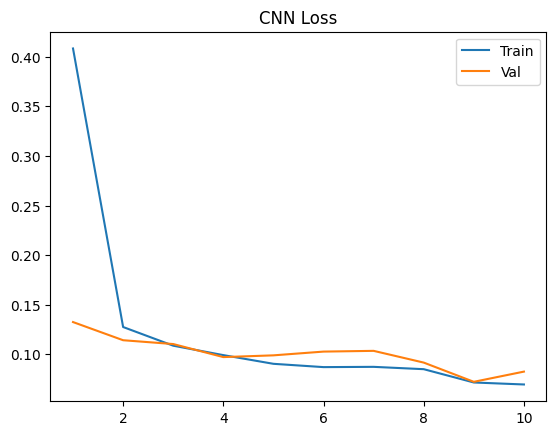

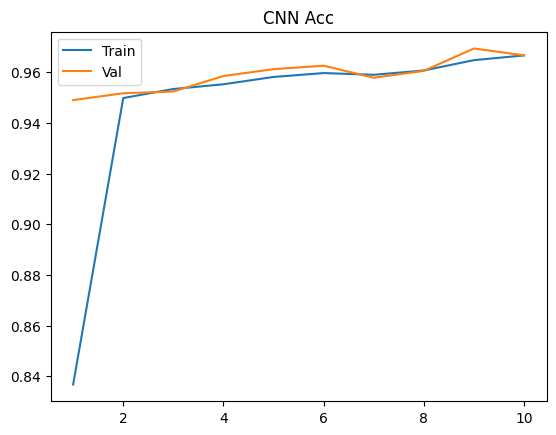

In [4]:
# plots
ep = range(1, len(hist.history['loss'])+1)
plt.figure(); plt.plot(ep, hist.history['loss']); plt.plot(ep, hist.history['val_loss']); plt.title('CNN Loss'); plt.legend(['Train','Val']); plt.show()
plt.figure(); plt.plot(ep, hist.history['accuracy']); plt.plot(ep, hist.history['val_accuracy']); plt.title('CNN Acc'); plt.legend(['Train','Val']); plt.show()

CNN Accuracy: 0.9294197488971836
              precision    recall  f1-score   support

           0     0.9704    0.9919    0.9811       496
           1     0.9610    0.9427    0.9518       471
           2     0.9363    0.9452    0.9408       420
           3     0.8285    0.8656    0.8466       491
           4     0.8810    0.8346    0.8571       532
           5     1.0000    1.0000    1.0000       537

    accuracy                         0.9294      2947
   macro avg     0.9295    0.9300    0.9296      2947
weighted avg     0.9296    0.9294    0.9293      2947



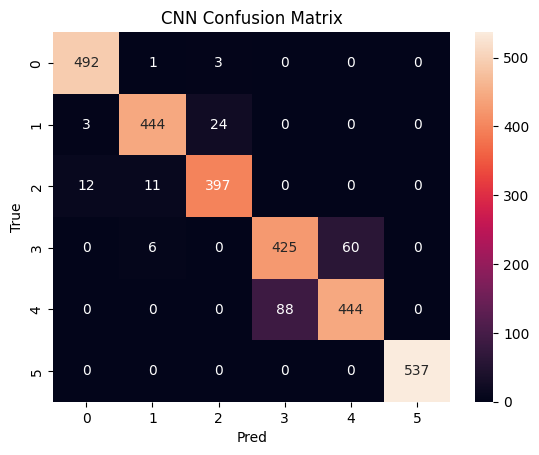

In [5]:
# eval
probs = model.predict(testX, verbose=0); pred = np.argmax(probs, axis=-1); y_true = testy.ravel()
cm = confusion_matrix(y_true, pred); print('CNN Accuracy:', accuracy_score(y_true, pred)); print(classification_report(y_true, pred, digits=4))
plt.figure(); sns.heatmap(cm, annot=True, fmt='d'); plt.title('CNN Confusion Matrix'); plt.xlabel('Pred'); plt.ylabel('True'); plt.show()